# Principal Component Analysis (PCA) and Neural Networks

# Principal component analysis (PCA)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


## Load or create a dataset with more than 2 dimensions.

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the data into 2D
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")


Training data shape: (60000, 784)
Test data shape: (10000, 784)


## Explore the data.

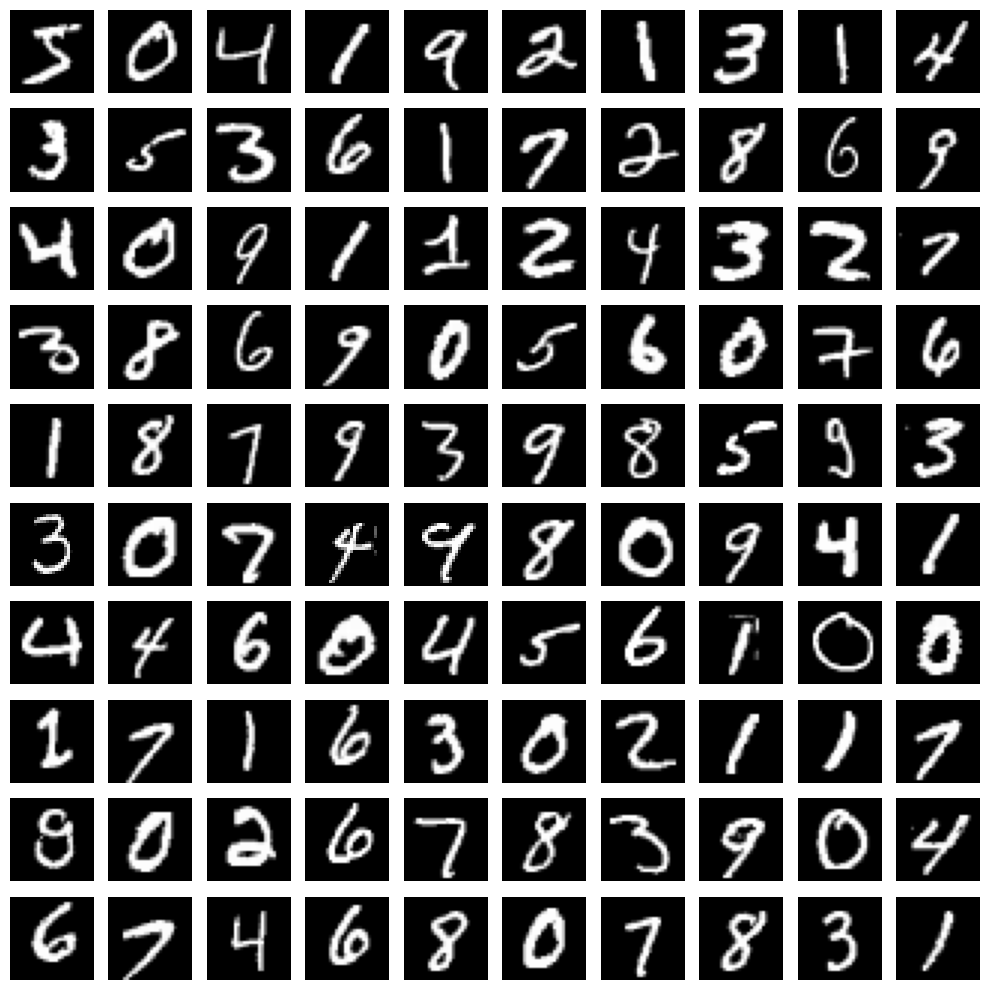

In [ ]:
def display_mnist_images(images, num_images=100, cmap='gray'):
    num_rows = int(np.sqrt(num_images))  # Calculate number of rows and columns for grid
    num_cols = num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_rows, num_cols))
    images = images.copy()
    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols

        # Reshape the image to (28, 28) before displaying
        image = images[i].reshape(28, 28)

        axes[row, col].imshow(image, cmap=cmap)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

display_mnist_images(x_train)

In [ ]:
# Step 1: Center the data
mean = np.mean(x_train, axis=0)
centered_data = x_train - mean

# Step 2: Compute the covariance matrix
covariance_matrix = np.cov(centered_data, rowvar=False)

# Step 3: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Step 4: Sort eigenvectors by eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
first_two_components = eigenvectors[:, sorted_indices[:2]]

# Step 5: Project the data onto the first two components
projected_data = np.dot(centered_data, first_two_components)

print(f"Shape of projected data: {projected_data.shape}")


Shape of projected data: (60000, 2)


## Find the first 2 principal components without using sklearn.

In [ ]:
pca = PCA(n_components=2)
projected_data_sklearn = pca.fit_transform(x_train)

print(f"Shape of projected data using sklearn: {projected_data_sklearn.shape}")


Shape of projected data using sklearn: (60000, 2)


## Find the first 2 principal components using sklearn.

In [ ]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the data
pca.fit(x_train_reshaped)

# Transform the data to the principal components
projected_data_sklearn = pca.transform(x_train_reshaped)

print("Projected data shape using sklearn:", projected_data_sklearn.shape)
print("First two principal components using sklearn:\n", pca.components_)

Projected data shape using sklearn: (60000, 2)
First two principal components using sklearn:
 [[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


## Practice using PCA to preserve a certain percentage of variance.

In [ ]:
# Define a function to perform PCA with variance threshold
def pca_with_variance(data, n_components=None, variance_threshold=None, pca=None):
    # Added pca object as an argument

    if pca is None: # Initialize pca if not provided
        if n_components is not None:
            pca = PCA(n_components=n_components)
        elif variance_threshold is not None:
            pca = PCA(n_components=variance_threshold, svd_solver='full')  # Ensures correct interpretation
        else:
            pca = PCA()  # Keep all components if neither is specified
    else:
        pass # If pca object is provided, reuse the existing pca settings

    transformed_data = pca.fit_transform(data) if pca is not None and not hasattr(pca, 'components_') else pca.transform(data) # Fit if pca is new else transform
    return transformed_data, pca.n_components_, pca


# Get the number of components from x_train using the desired variance threshold
transformed_train, num_components, pca = pca_with_variance(x_train, variance_threshold=0.95)  # Store the fitted pca object
print(f"Number of components to preserve 95% variance: {num_components}")

Number of components to preserve 95% variance: 154


## Train a classification or regression neural network using original dataset

In [ ]:
# Define and train a neural network
def train_nn(input_shape, x_train, y_train, x_test, y_test, epochs=10):
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)  # Adjust batch size if needed
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_dataset, epochs=epochs, verbose=1)  # train_dataset is now a tf.data.Dataset
    loss, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return model, accuracy

# Train using original dataset
train_nn((x_train.shape[1],), x_train, y_train, x_test, y_test)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8798 - loss: 0.4289
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9609 - loss: 0.1336
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9738 - loss: 0.0889
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9818 - loss: 0.0630
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9856 - loss: 0.0478
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9899 - loss: 0.0355
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9938 - loss: 0.0265
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9945 - loss: 0.0210
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9955 - loss: 0.0174
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9961 - loss: 0.0138
Test Loss: 0.1010, Test Accuracy: 0.9765


(<Sequential name=sequential_7, built=True>, 0.9764999747276306)

## Train a classification or regression neural network using principal components

In [ ]:
transformed_train, num_components, _ = pca_with_variance(x_train, variance_threshold=0.95) # Unpack all three returned values
transformed_test, _, _ = pca_with_variance(x_test, variance_threshold=0.95, pca=_) # Reuse the fitted pca object and unpack all three returned values

train_nn((num_components,), transformed_train, y_train, transformed_test, y_test)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8378 - loss: 0.5998
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9616 - loss: 0.1336
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9758 - loss: 0.0847
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9833 - loss: 0.0593
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9888 - loss: 0.0434
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9926 - loss: 0.0322
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9952 - loss: 0.0237
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9974 - loss: 0.0172
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9987 - loss: 0.0122
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9993 - loss: 0.0083
Test Loss: 0.0869, Test Accuracy: 0.9767


(<Sequential name=sequential_8, built=True>, 0.9767000079154968)

## Train a classification or regression neural network using Kernel PCA (linear, sigmoid, RBF).

In [ ]:
def train_kernel_pca(
        x_train, y_train, x_test, y_test,
        kernels, gamma_values=None, n_components=10,
        epochs=5, subset_size=5000):
    # Reduce dataset size for training and testing
    x_train_small, y_train_small = x_train[:subset_size], y_train[:subset_size]
    x_test_small, y_test_small = x_test[:subset_size], y_test[:subset_size]

    # Scale the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_small)
    x_test_scaled = scaler.transform(x_test_small)

    for kernel in kernels:
        if kernel == 'rbf' and gamma_values:
            for gamma in gamma_values:
                kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components=n_components)

                print(f"Fitting Kernel PCA with kernel={kernel} and gamma={gamma}")
                x_train_kpca = kpca.fit_transform(x_train_scaled)
                x_test_kpca = kpca.transform(x_test_scaled)

                print(f"Training NN for kernel={kernel}, gamma={gamma}")
                train_nn((n_components,), x_train_kpca, y_train_small, x_test_kpca, y_test_small, epochs)
        else:
            kpca = KernelPCA(kernel=kernel, n_components=n_components)

            print(f"Fitting Kernel PCA with kernel={kernel}")
            x_train_kpca = kpca.fit_transform(x_train_scaled)
            x_test_kpca = kpca.transform(x_test_scaled)

            print(f"Training NN for kernel={kernel}")
            train_nn((n_components,), x_train_kpca, y_train_small, x_test_kpca, y_test_small, epochs)


# Run Kernel PCA training with reduced settings
kernels = ['linear', 'sigmoid', 'rbf']
gamma_values = [0.01, 0.1]  # Reduce gamma values to avoid overload
train_kernel_pca(x_train, y_train, x_test, y_test, kernels=kernels, gamma_values=gamma_values, n_components=10, epochs=5, subset_size=5000)


Fitting Kernel PCA with kernel=linear
Training NN for kernel=linear
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5658 - loss: 1.4416
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8265 - loss: 0.5706
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8551 - loss: 0.4856
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8694 - loss: 0.4357
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8759 - loss: 0.3996
Test Loss: 0.5155, Test Accuracy: 0.8342
Fitting Kernel PCA with kernel=sigmoid
Training NN for kernel=sigmoid
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4100 - loss: 2.2043
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6662 - loss: 1.5586
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7389 - loss: 1.0441
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7726 - loss: 0.8355
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc

## Build a pipeline to tune the hyperparameters of Kernel PCA and also the neural network. Which hyperparameters can be tuned?

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Build a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', KernelPCA()),
    ('mlp', MLPClassifier(max_iter=100))
])


# Define parameter grid
param_grid = {
    'kpca__kernel': ['linear', 'rbf', 'sigmoid'],
    'kpca__gamma': [0.01, 0.1, 1.0],
    'mlp__hidden_layer_sizes': [(100,), (128, 64)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001]
}


# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2)


subset_size = 5000  # Choose a low size to avoid occupying the whole RAM leading to crashes
x_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]
grid_search.fit(x_train_subset, y_train_subset)


print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=   9.7s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=   7.7s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=   7.5s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=   7.7s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=   6.7s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=   7.5s
[CV] END kpca__gamma=0.01, kpca__kernel=linear, mlp__activation=relu, mlp__alpha=0.001, m

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=  37.0s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,); total time=  36.3s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=  22.5s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=  23.7s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64); total time=  25.3s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=  35.1s
[CV] END kpca__gamma=1.0, kpca__kernel=rbf, mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,); total time=  33.3s
[CV] END kpca__gamma=1.0, kpca__kernel=rb

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
72 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/skl

Best parameters: {'kpca__gamma': 0.1, 'kpca__kernel': 'linear', 'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128, 64)}
Best accuracy: 0.8941997914942822


# Classification problem

## source: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

In [ ]:
!pip install scikeras[tensorflow]

### Import Libraries

In [ ]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Perceptron
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import random
from scipy.stats import reciprocal


### Set Random Seed for Reproducibility

In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Load IRIS and MNIST fashion datasets from Keras.

Load Datasets (IRIS and Fashion MNIST)

In [ ]:
# Load IRIS dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Split IRIS data
X_train_iris, X_temp_iris, y_train_iris, y_temp_iris = train_test_split(X_iris, y_iris, test_size=0.3, random_state=42)
X_val_iris, X_test_iris, y_val_iris, y_test_iris = train_test_split(X_temp_iris, y_temp_iris, test_size=0.5, random_state=42)

# One-hot encode IRIS labels
lb = LabelBinarizer()
y_train_iris = lb.fit_transform(y_train_iris)
y_val_iris = lb.transform(y_val_iris)
y_test_iris = lb.transform(y_test_iris)

# Load Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_fashion_full, y_train_fashion_full), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Split and preprocess Fashion MNIST
X_val_fashion, X_train_fashion = X_train_fashion_full[:5000] / 255., X_train_fashion_full[5000:] / 255.
y_val_fashion, y_train_fashion = y_train_fashion_full[:5000], y_train_fashion_full[5000:]
X_test_fashion = X_test_fashion / 255.


### Visualize Fashion MNIST samples

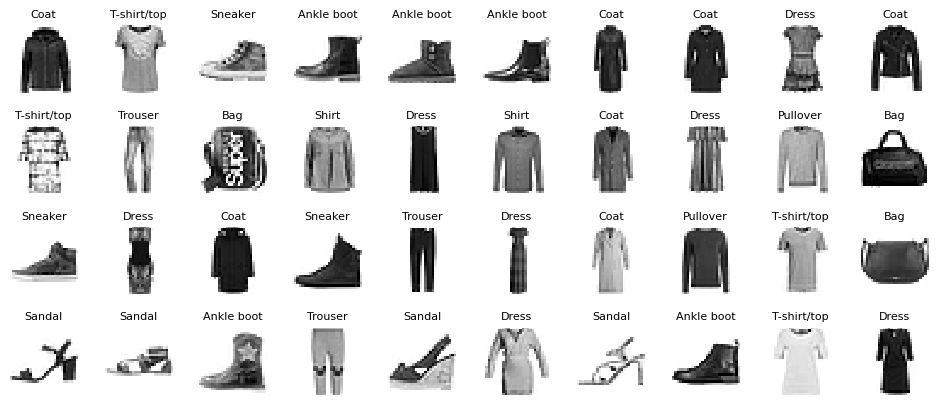

In [ ]:
# Visualize Fashion MNIST samples
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_rows, n_cols = 4, 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_fashion[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train_fashion[index]], fontsize=8)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


### Build Artificial Neural Networks (ANNs).

In [ ]:
# Define NN for IRIS dataset
def build_model_iris(n_hidden=1, n_neurons=30, learning_rate=3e-3, activation='tanh', input_shape=(4,)):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Define NN for Fashion MNIST dataset
def build_model_fashion(n_hidden=1, n_neurons=30, learning_rate=3e-3, activation='tanh', input_shape=(28, 28)):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape))
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model


#### Train ANNs.

In [ ]:
# Train IRIS NN
model_iris = build_model_iris(n_hidden=2, n_neurons=50, learning_rate=0.01, activation='relu')
history_iris = model_iris.fit(X_train_iris, y_train_iris, epochs=30,
                               validation_data=(X_val_iris, y_val_iris))

# Train Fashion MNIST NN
# Convert y_train_fashion and y_val_fashion to one-hot encoding
y_train_fashion_encoded = tf.keras.utils.to_categorical(y_train_fashion, num_classes=10)
y_val_fashion_encoded = tf.keras.utils.to_categorical(y_val_fashion, num_classes=10)
y_test_fashion_encoded = tf.keras.utils.to_categorical(y_test_fashion, num_classes=10)

model_fashion = build_model_fashion(n_hidden=2, n_neurons=100, learning_rate=0.01, activation='relu')
history_fashion = model_fashion.fit(X_train_fashion, y_train_fashion_encoded, epochs=30,
                                     validation_data=(X_val_fashion, y_val_fashion_encoded))


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.3399 - loss: 1.3463 - val_accuracy: 0.6364 - val_loss: 1.0126
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4301 - loss: 1.0958 - val_accuracy: 0.7273 - val_loss: 0.9509
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6365 - loss: 1.0090 - val_accuracy: 0.8636 - val_loss: 0.9238
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6556 - loss: 0.9705 - val_accuracy: 0.8636 - val_loss: 0.9056
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6580 - loss: 0.9469 - val_accuracy: 0.8636 - val_loss: 0.8880
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6580 - loss: 0.9271 - val_accuracy: 0.8636 - val_loss: 0.8696
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6580 - loss: 0.9089 - val_accuracy: 0.8636 - val_loss: 0.8497
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6580 - loss: 0.8929 - val_accuracy: 0.8636 - val_loss: 0.8289

### Plot training history.

In [108]:
def plot_history(history, title=""):
    df = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 5))
    plt.plot(df['accuracy'], label='Train Accuracy')
    plt.plot(df['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    # plt.ylim(0, 1)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(df['loss'], label='Train Loss')
    plt.plot(df['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title + " Loss")
    plt.legend()
    plt.grid(True)
    # plt.ylim(0, 1)
    plt.show()


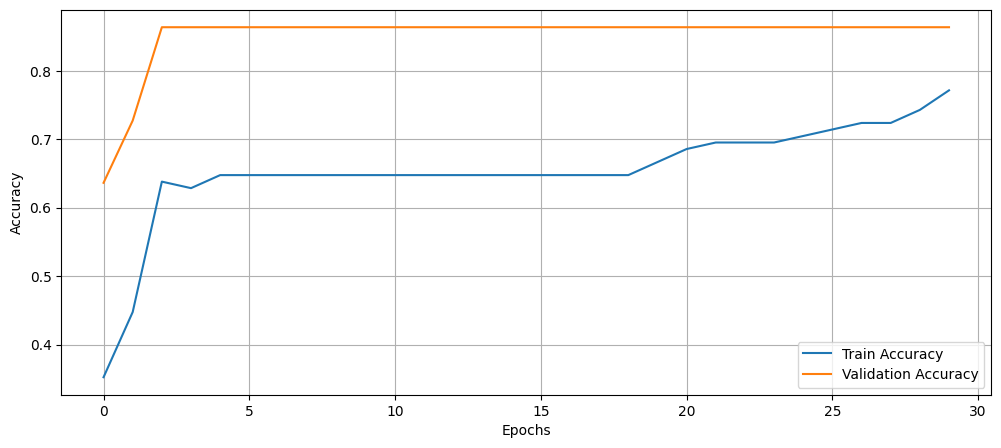

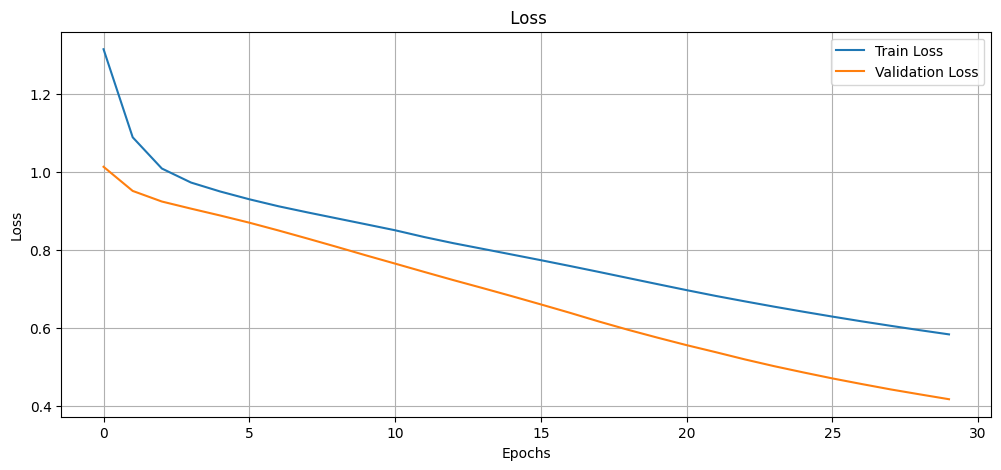

In [109]:
plot_history(history_iris)

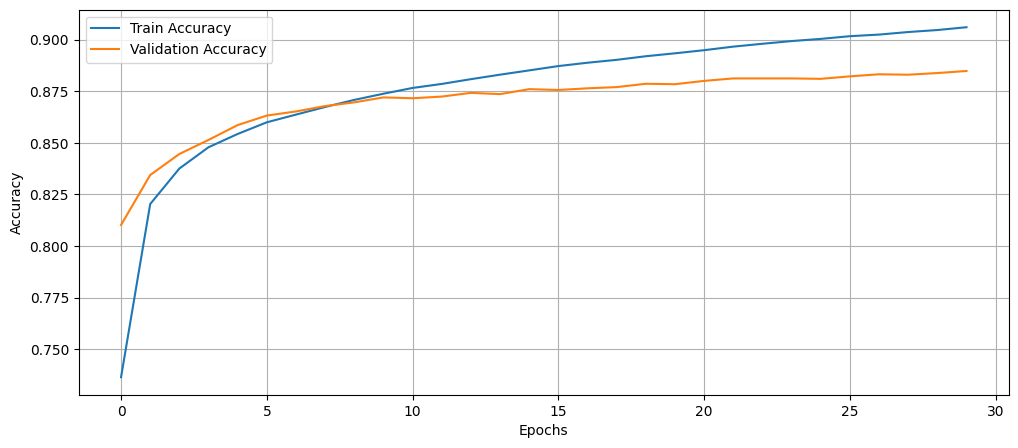

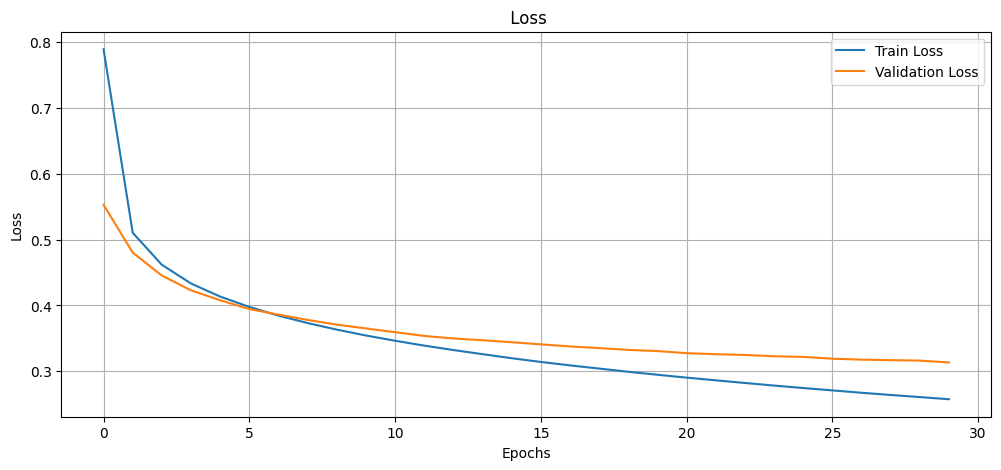

In [110]:
plot_history(history_fashion)

### Save and load models.

In [ ]:
# Save the trained Iris and Fashion MNIST models in the Keras format.
# This format is recommended for better compatibility and future-proofing.
model_iris.save("iris_model.keras")  # Save the Iris model to 'iris_model.keras'
model_fashion.save("fashion_model.keras")  # Save the Fashion MNIST model to 'fashion_model.keras'

# Reload the saved Iris and Fashion MNIST models.
model_iris_reloaded = tf.keras.models.load_model("iris_model.keras")  # Load the Iris model
model_fashion_reloaded = tf.keras.models.load_model("fashion_model.keras")  # Load the Fashion MNIST model

# Compile the reloaded Iris model with the original optimizer and settings.
# This is important to ensure consistency and avoid optimizer mismatch warnings.
# We use the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.01.
# The loss function is categorical cross-entropy, suitable for multi-class classification.
# Accuracy is used as the evaluation metric.
model_iris_reloaded.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                           loss="categorical_crossentropy",
                           metrics=["accuracy"])

### Tune Hyperparameters with RandomizedSearchCV

In [96]:
# Use SciKeras for IRIS hyperparameter tuning
from scikeras.wrappers import KerasClassifier

keras_clf_iris = KerasClassifier(model=build_model_iris, input_shape=(4,))
keras_clf_fashion = KerasClassifier(model=build_model_fashion, input_shape=(28, 28))


param_distribs = {
    "model__n_hidden": [1, 3, 5, 7],
    "model__n_neurons": [10, 50, 100],
    "model__learning_rate": reciprocal(0.001, 0.1).rvs(1000).tolist(),
    "model__activation": ['mish', 'swish', tf.keras.layers.PReLU()]
}

# Perform RandomizedSearchCV for iris
rnd_search_cv_iris = RandomizedSearchCV(
    keras_clf_iris,
    param_distribs,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42
)


# Perform RandomizedSearchCV for fashion MNIST
rnd_search_cv_fashion = RandomizedSearchCV(
    keras_clf_fashion,
    param_distribs,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42
)

rnd_search_cv_iris.fit(
    X_train_iris,
    y_train_iris,
    validation_data=(X_val_iris, y_val_iris),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
)

rnd_search_cv_fashion.fit(
    X_train_fashion,
    y_train_fashion_encoded,
    validation_data=(X_val_fashion, y_val_fashion_encoded),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
)

# Display the best hyperparameters and validation accuracy
print(f"Best Params (Fashion MNIST): {rnd_search_cv_fashion.best_params_}")
print(f"Best Params (Fashion MNIST): {rnd_search_cv_fashion.best_params_}")

# Display the best hyperparameters and validation accuracy
print(f"Best Params (iris): {rnd_search_cv_iris.best_params_}")
print(f"Best Validation Accuracy (iris): {rnd_search_cv_iris.best_score_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5904 - loss: 1.4104 - val_accuracy: 0.6364 - val_loss: 0.9926
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3953 - loss: 1.1196 - val_accuracy: 0.5909 - val_loss: 0.9294
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3654 - loss: 1.0509 - val_accuracy: 0.5909 - val_loss: 0.8697
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3355 - loss: 1.0056 - val_accuracy: 0.5909 - val_loss: 0.8022
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3465 - loss: 0.9631 - val_accuracy: 0.8182 - val_loss: 0.7308
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5384 - loss: 0.9207 - val_accuracy: 0.8636 - val_loss: 0.6625
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6489 - loss: 0.8792 - val_accuracy: 0.8636 - val_loss: 0.6025
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.

### Train optimal model.

In [100]:
# Extract best parameters for IRIS
best_params_iris = rnd_search_cv_iris.best_params_

# Extract best parameters for Fashion MNIST
best_params_fashion = rnd_search_cv_fashion.best_params_

# Build and train the model with the best parameters for IRIS
optimal_model_iris = build_model_iris(
    n_hidden=best_params_iris['model__n_hidden'],
    n_neurons=best_params_iris['model__n_neurons'],
    learning_rate=best_params_iris['model__learning_rate'],
    activation=best_params_iris['model__activation']
)

# Build and train the model with the best parameters for Fashion MNIST
optimal_model_fashion = build_model_fashion(
    n_hidden=best_params_fashion['model__n_hidden'],
    n_neurons=best_params_fashion['model__n_neurons'],
    learning_rate=best_params_fashion['model__learning_rate'],
    activation=best_params_fashion['model__activation']
)

history_optimal_iris = optimal_model_iris.fit(
    X_train_iris,
    y_train_iris,
    epochs=30,
    validation_data=(X_val_iris, y_val_iris),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint('optimal_iris_model.keras', save_best_only=True)
    ]
)

history_optimal_fashion = optimal_model_fashion.fit(
    X_train_fashion,
    y_train_fashion_encoded,
    epochs=30,
    validation_data=(X_val_fashion, y_val_fashion_encoded),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint('optimal_fashion_model.keras', save_best_only=True)
    ]
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.4388 - loss: 2.0010 - val_accuracy: 0.2727 - val_loss: 0.9612
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4242 - loss: 1.0464 - val_accuracy: 0.8636 - val_loss: 0.8452
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6344 - loss: 0.9569 - val_accuracy: 0.8636 - val_loss: 0.7399
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6344 - loss: 0.8789 - val_accuracy: 0.8636 - val_loss: 0.6398
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6344 - loss: 0.8053 - val_accuracy: 0.8636 - val_loss: 0.5501
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6403 - loss: 0.7374 - val_accuracy: 0.8636 - val_loss: 0.4764
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6403 - loss: 0.6778 - val_accuracy: 0.8636 - val_loss: 0.4193
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6462 - loss: 0.6278 - val_accuracy: 0.8636 - val_loss: 0.3764

### Plot hiatory.

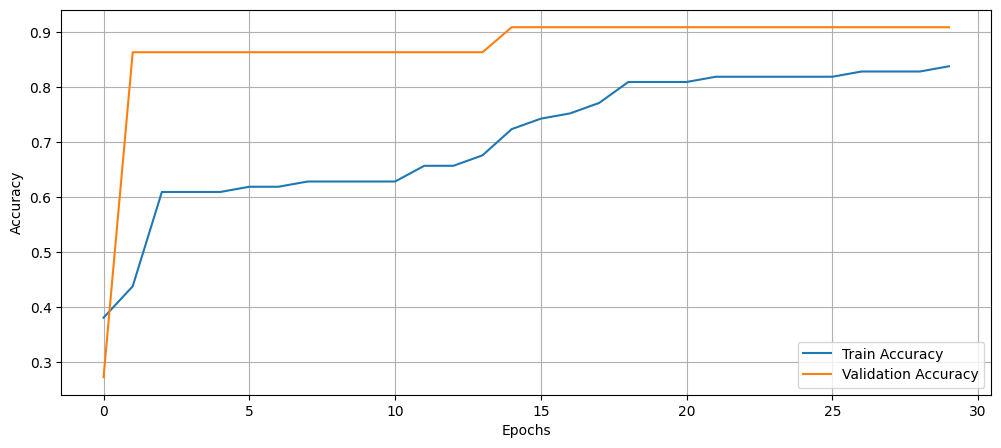

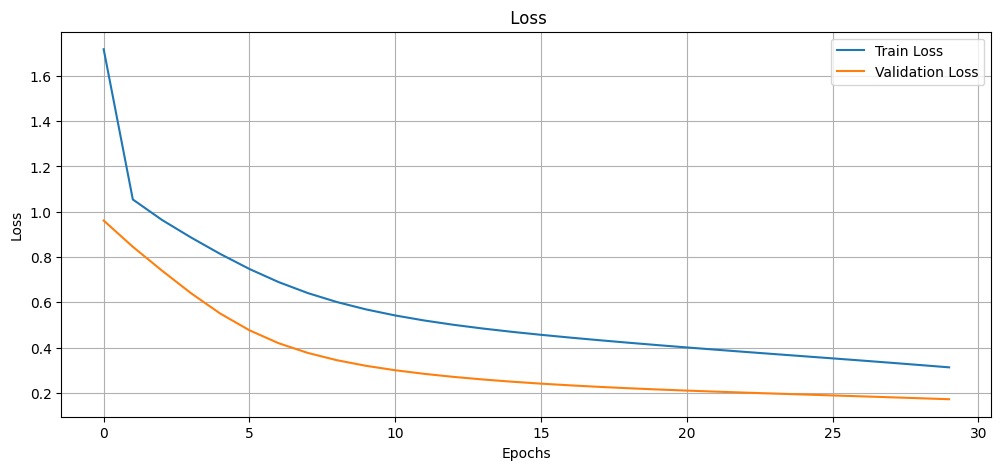

In [111]:
# Plot the training and validation accuracy over epochs
plot_history(history_optimal_iris)

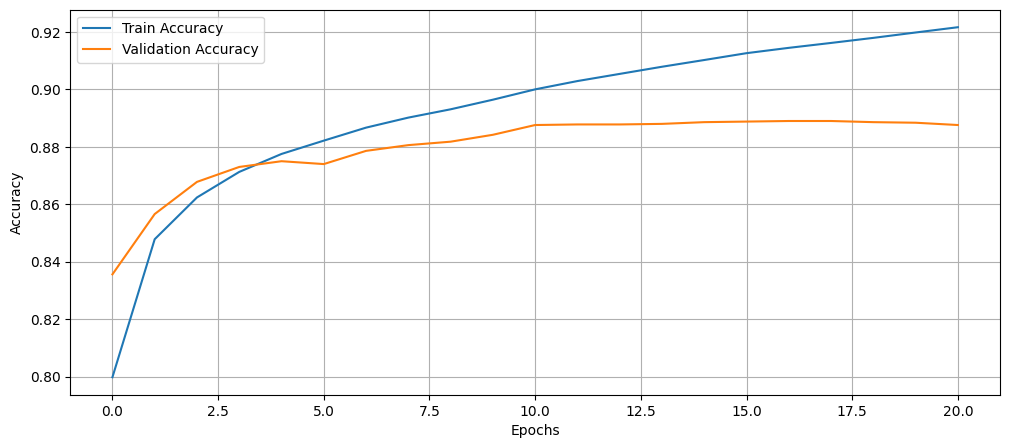

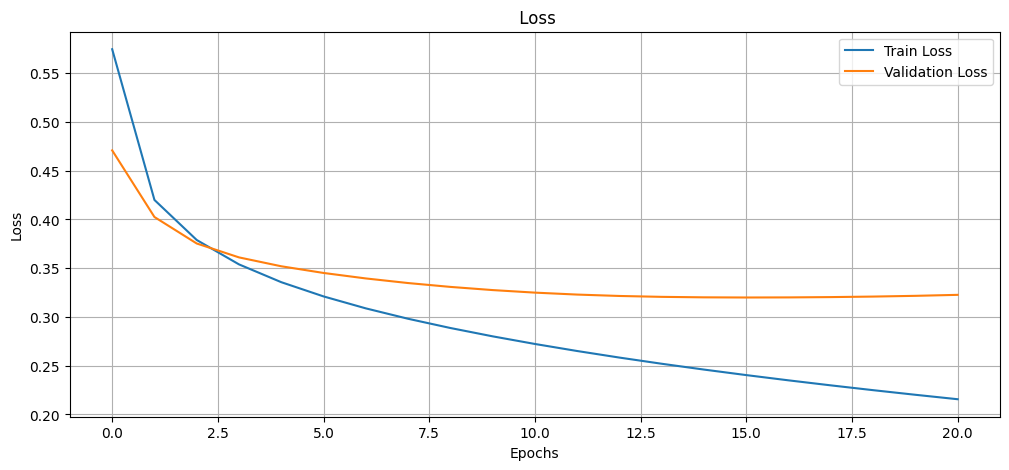

In [112]:
# Plot the training and validation accuracy over epochs
plot_history(history_optimal_fashion)

# Regression problem

## Load California housing dataset and split it to training and testing datasets.

## Clone the repository.

In [ ]:
!git clone https://github.com/ageron/handson-ml2.git

Cloning into 'handson-ml2'...
remote: Enumerating objects: 3100, done.
remote: Total 3100 (delta 0), reused 0 (delta 0), pack-reused 3100 (from 1)
Receiving objects: 100% (3100/3100), 150.50 MiB | 26.76 MiB/s, done.
Resolving deltas: 100% (1907/1907), done.


## Load the dataset and split it.

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Load dataset
housing = pd.read_csv('/content/handson-ml2/datasets/housing/housing.csv')
data, labels = housing.drop('median_house_value', axis=1), housing['median_house_value']

# Stratified split
stratify = pd.qcut(labels, q=20, labels=False)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=stratify, random_state=42)

# Further split training data into train and validation sets
stratify = pd.qcut(y_train, q=20, labels=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=stratify, random_state=42)


### Preprocess the data

In [ ]:
# Import preprocessing modules
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define preprocessing pipelines
numeric_features = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
categorical_features = ['ocean_proximity']

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

# Preprocess datasets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Scale labels
from sklearn.preprocessing import StandardScaler
label_scaler = StandardScaler()
y_train_scaled = label_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_val_scaled = label_scaler.transform(y_val.to_numpy().reshape(-1, 1))
y_test_scaled = label_scaler.transform(y_test.to_numpy().reshape(-1, 1))


## Build and train a neural network for price prediction. Tune the hyperparameters and discuss the results.

### Define the Neural Network Model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define neural network model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.network(x)

# Define training function
def train_model(model, train_loader, val_loader, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        history.append((train_loss, val_loss))
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    return history


In [ ]:
# Prepare data for PyTorch
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)
y_train_transformed = label_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_val_transformed = label_scaler.transform(y_val.to_numpy().reshape(-1, 1))
y_test_transformed = label_scaler.transform(y_test.to_numpy().reshape(-1, 1))
# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train_transformed, dtype=torch.float32),
                               torch.tensor(y_train_transformed, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val_transformed, dtype=torch.float32),
                             torch.tensor(y_val_transformed, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train with learning rate = 0.01
model_lr1 = RegressionModel(input_dim=X_train_transformed.shape[1])
history_lr1 = train_model(model_lr1, train_loader, val_loader, epochs=20, lr=0.01)

# Train with learning rate = 0.001
model_lr2 = RegressionModel(input_dim=X_train_transformed.shape[1])
history_lr2 = train_model(model_lr2, train_loader, val_loader, epochs=20, lr=0.001)


Epoch 1/20, Train Loss: 0.3675, Val Loss: 0.3275
Epoch 2/20, Train Loss: 0.3289, Val Loss: 0.3273
Epoch 3/20, Train Loss: 0.3230, Val Loss: 0.3230
Epoch 4/20, Train Loss: 0.3160, Val Loss: 0.3357
Epoch 5/20, Train Loss: 0.3166, Val Loss: 0.3349
Epoch 6/20, Train Loss: 0.3119, Val Loss: 0.3222
Epoch 7/20, Train Loss: 0.3078, Val Loss: 0.3251
Epoch 8/20, Train Loss: 0.3084, Val Loss: 0.3251
Epoch 9/20, Train Loss: 0.3111, Val Loss: 0.3381
Epoch 10/20, Train Loss: 0.3145, Val Loss: 0.3332
Epoch 11/20, Train Loss: 0.3074, Val Loss: 0.3212
Epoch 12/20, Train Loss: 0.3050, Val Loss: 0.3168
Epoch 13/20, Train Loss: 0.3053, Val Loss: 0.3119
Epoch 14/20, Train Loss: 0.3029, Val Loss: 0.3233
Epoch 15/20, Train Loss: 0.3031, Val Loss: 0.3277
Epoch 16/20, Train Loss: 0.3006, Val Loss: 0.3160
Epoch 17/20, Train Loss: 0.2993, Val Loss: 0.3169
Epoch 18/20, Train Loss: 0.2975, Val Loss: 0.3378
Epoch 19/20, Train Loss: 0.2989, Val Loss: 0.3266
Epoch 20/20, Train Loss: 0.2990, Val Loss: 0.3118
Epoch 1/2

### Plot the history

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrames for both histories
history_df_lr1 = pd.DataFrame(history_lr1, columns=['train_loss', 'val_loss'])
history_df_lr2 = pd.DataFrame(history_lr2, columns=['train_loss', 'val_loss'])

# Plot history for both learning rates
def plot_training_history(history_df, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history_df['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(history_df['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()



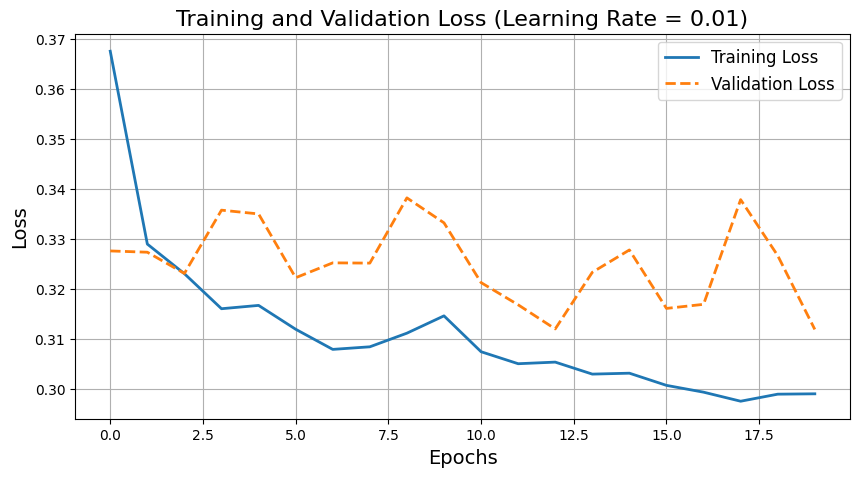

In [ ]:
# Plot for learning rate = 0.01
plot_training_history(history_df_lr1, "Training and Validation Loss (Learning Rate = 0.01)")


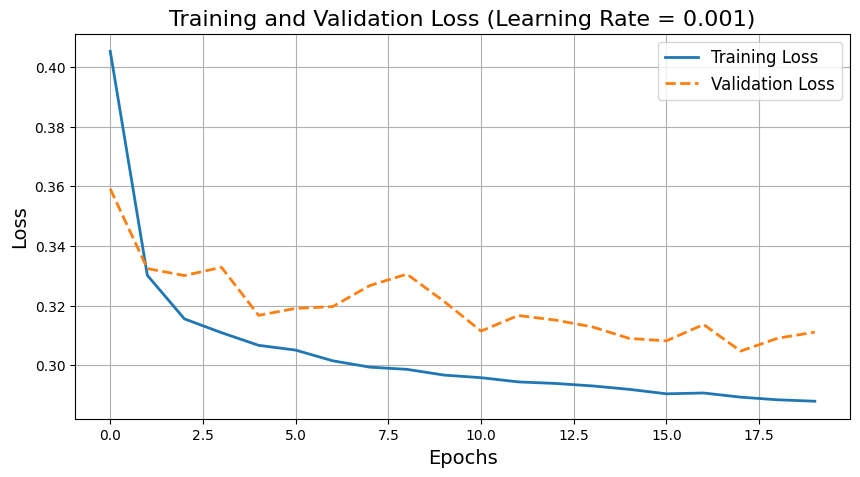

In [ ]:
# Plot for learning rate = 0.001
plot_training_history(history_df_lr2, "Training and Validation Loss (Learning Rate = 0.001)")


## Save the weights of the layers and use callbacks during the training process. Practice saving and loading the trained mode

In [ ]:
# Save both models
torch.save(model_lr1.state_dict(), 'model_lr1.pth')
torch.save(model_lr2.state_dict(), 'model_lr2.pth')

# Reload models
reloaded_model_lr1 = RegressionModel(input_dim=X_train_transformed.shape[1])
reloaded_model_lr1.load_state_dict(torch.load('model_lr1.pth'))

reloaded_model_lr2 = RegressionModel(input_dim=X_train_transformed.shape[1])
reloaded_model_lr2.load_state_dict(torch.load('model_lr2.pth'))


<ipython-input-59-a4ae1c0ec9e8>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reloaded_model_lr1.load_state_dict(torch.load('model_lr1.pth'))
<ipython-input-59-a4ae1c0ec9

<All keys matched successfully>